In [1]:
import numpy as np
from itertools import combinations
import progressbar
import itertools 
import networkx as nx
import pickle

In [100]:
def nodes_connected(graph, u, v):
     return u in graph.neighbors(v)


def make_graph(hashtag_list_of_lists,success_list,savename='instagraph'):
    tag_graph = nx.Graph()
    for ind,hashtag_list in progressbar.progressbar(enumerate(hashtag_list_of_lists)):
        for hashtag in hashtag_list:
            if hashtag in tag_graph.nodes:
                success = tag_graph.nodes[hashtag]['success'] + success_list[ind]
                occurence = tag_graph.nodes[hashtag]['occurence'] + 1.0
                
            else:
                success = success_list[ind]
                occurence = 1.0                
            tag_graph.add_node(hashtag, success=success,occurence=occurence)
        
        for a,b in itertools.combinations(hashtag_list,2):
            if nodes_connected(tag_graph,a,b):
                tag_graph[a][b]['weight']+=1
            else:
                tag_graph.add_edge(a,b,weight=1)
    with open(savename, 'wb') as f:
        pickle.dump(tag_graph,f)
    return tag_graph

In [206]:
import pandas as pd
import sys

filepath = 'C:\\Users\\Swooty\\Documents\\Data science\\DataIncubator\\twitter\\insta_data\\media.csv'
df = pd.read_csv(filepath, sep=';', encoding='iso-8859-1')

df_has_tags = df.loc[pd.notnull(df['comments'])]
df_has_tags['tagset'] = df_has_tags['tagset'].apply(lambda x: x.split(','))

first_1000_posts = df_has_tags['tagset'].tolist()[0:100000]
likes_list = df_has_tags['likes'].tolist()[0:100000]

C:\Users\Swooty\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [207]:
graph = make_graph(first_1000_posts,likes_list)

| |                               #               | 99999 Elapsed Time: 0:00:34


In [212]:
graph.nodes['costarica']

{'success': 406, 'occurence': 28.0}

In [170]:
scaled_success_list = []

for node in graph.nodes:
    ss = graph.nodes[node]['success']/graph.nodes[node]['occurence']
    occ = graph.nodes[node]['occurence']
    scaled_success_list.append((node,ss,occ))
best_tag = sorted(scaled_success_list, key = lambda x: -x[1])[0][0]
common_tag = sorted(scaled_success_list, key = lambda x: -x[2])[35][0]
print(sorted(scaled_success_list, key = lambda x: -x[2])[:30])


[('instamarinda', 295.9255319148936, 188.0), ('instagood', 173.36263736263737, 182.0), ('biatoxic', 146.0056179775281, 178.0), ('instago', 113.42207792207792, 154.0), ('webstagram', 127.66442953020135, 149.0), ('instamood', 147.10714285714286, 140.0), ('instagramhub', 171.6890756302521, 119.0), ('igers_eb', 69.20408163265306, 98.0), ('iphonesia', 229.51546391752578, 97.0), ('igers', 73.8936170212766, 94.0), ('indonesia', 56.40229885057471, 87.0), ('sgs2', 58.16867469879518, 83.0), ('samarinda', 52.48051948051948, 77.0), ('instaaaaah', 286.6041666666667, 48.0), ('instaxlent', 402.93617021276594, 47.0), ('photooftheday', 316.83720930232556, 43.0), ('iphoneonly', 346.4146341463415, 41.0), ('all_shots', 316.1794871794872, 39.0), ('iphoneography', 127.64102564102564, 39.0), ('instasunda', 490.4736842105263, 38.0), ('vscocam', 276.27777777777777, 36.0), ('ampt_community', 395.6857142857143, 35.0), ('instameetbromo', 473.0625, 32.0), ('instadaily', 265.3225806451613, 31.0), ('im_team', 400.86

In [220]:
def make_sub_graph(center_tag,occurence_cutoff = 0, success_cutoff = 0):
    sub_graph = nx.Graph()
    sub_graph.add_node(center_tag, 
                       success = graph.nodes[center_tag]['success'],
                       occurence = graph.nodes[center_tag]['occurence'],
                       ss = graph.nodes[center_tag]['success']/graph.nodes[center_tag]['occurence'])
    
    for tag in graph.neighbors(center_tag):
        if graph.nodes[tag]['occurence']>occurence_cutoff:
            if graph.nodes[tag]['success']/graph.nodes[tag]['occurence']>success_cutoff:
                sub_graph.add_node(tag,
                           success = graph.nodes[tag]['success'],
                           occurence = graph.nodes[tag]['occurence'],
                           ss = graph.nodes[tag]['success']/graph.nodes[tag]['occurence'])

    for a,b in itertools.combinations(sub_graph.nodes,2):
        if nodes_connected(graph,a,b):
            sub_graph.add_edge(a,b,weight = graph[a][b]['weight'])
        
    return sub_graph

In [229]:
def get_sub_graph_sizes(sub_graph):
    node_size_list = []
    occurence_list = []
    for node in sub_graph.nodes:
        node_size_list.append(sub_graph.nodes[node]['ss'])
        occurence_list.append(sub_graph.nodes[node]['occurence'])
        
    edge_width_list = []
    for a,b in sub_graph.edges:
        occ_a = sub_graph.nodes[a]['occurence']
        occ_b = sub_graph.nodes[b]['occurence']
        edge_width_list.append(float(sub_graph[a][b]['weight'])/float(occ_a)/float(occ_b))
        
    return node_size_list, occurence_list, edge_width_list

In [230]:
sub_graph = make_sub_graph('costarica',occurence_cutoff=30, success_cutoff=200)
node_size_list, occurence_list, edge_width_list = get_sub_graph_sizes(sub_graph)
len(node_size_list)

6

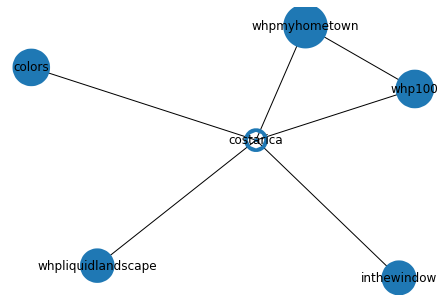

In [232]:
import matplotlib.pyplot as  plt
nx.drawing.nx_pylab.draw(sub_graph, 
                         linewidths = 20,
                         node_size = node_size_list, 
                       #  width = 10*edge_width_list,
                         edge_color = 'k',
                         with_labels=True)
plt.savefig('sample_graph.png', dpi=300, bbox_inches='tight')